<div id="instructions" style="border-radius: 5px; background-color:#f5f5f5;" >
<h1>Instructions</h1>
<p>Look for the <b>4 Your Turn</b> sections to complete the code and/or answer questions.<p>
</div>

# Lesson 7 - Theory of Regression and Regularization

In this notebook we will explore the mathematical basis of linear statistical models. The emphasis is on the ubiquitous problem of **model overfitting** or **model over-parameterization**. 

Overfitting (or over-parameterization) of machine learning models arises in any case where the number of model parameters exceeds the effective dimensions of the feature set. This is most often the result of linear dependency between the features. However, using too complex a model can lead to similar problems. In the extreme case, imagine a model with as many free parameters as training cases. This model might fit the training data perfectly, but will show unstable and unexpected results when used for other data. In machine learning terminology, we say that such an unstable model does not **generalize**. 

Many methods have been developed and continue to be developed to deal with over-parameterized or **ill-posed** machine learning models. In particular, in this notebook we will explore three methods for stabilizing over-parameterized models: 

- Stepwise regression, wherein features are eliminated from an over-parameterized model in a stepwise fashion
- Using a mathematical **regularization** technique, known as singular value decomposition, to determine the number of meaningful components for a model.
- Using **regularization** methods known as ridge, lasso, and elastic-net regression to stabilize over-parameterized models.



***
**Note:** To run the code in this note book you must have installed the following packages:
 - pandas
 - numpy
 - seaborn
 - scikit-learn
 - statsmodels
 - matplotlib
***

## Stepwise Regression

In this section we will work through an example of stepwise regression using the Galton family height data (http://www.randomservices.org/random/data/Galton.html). The goal of the model is to predict the height of adult children given information on the height of their parents. 

<small>Francis Galton, 2017, "Galton height data", https://doi.org/10.7910/DVN/T0HSJ1, Harvard Dataverse, V1</small>

### Preparing the Data

As a first step we will create a data set for just the adult male children. The code in the cell below performs the following operations:

- Subset the data to just male adult children.
- Compute two new features, the heights of the parents squared.
- Z score scale the features.

Execute this code to prepare the data. 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load Data
data_file = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/galton.txt'
family_data = pd.read_csv(data_file, delimiter='\t')

# Label the columns
family_data.columns = ["family","father","mother","gender","childHeight", "kids"]

# Preview the data
family_data.head()

,family,father,mother,gender,childHeight,kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


In [3]:
# Check data types for numeric data types
family_data.dtypes

family          object
father         float64
mother         float64
gender          object
childHeight    float64
kids             int64
dtype: object

In [5]:
# family_data[family_data.gender == 'M'].head()

In [7]:
# Subset the data with a Boolean Flag
isMale = family_data.loc[:,"gender"] == "M"

# Create just the male dataframe
male_only = family_data[isMale].copy()

# Preview the new dataframe
male_only.head()


,family,father,mother,gender,childHeight,kids
0,1,78.5,67.0,M,73.2,4
4,2,75.5,66.5,M,73.5,4
5,2,75.5,66.5,M,72.5,4
8,3,75.0,64.0,M,71.0,2
10,4,75.0,64.0,M,70.5,5


In [8]:
# Display counts of the data frames
print('Number of rows: {}, Number of Males: {}'.format(len(family_data), len(male_only)))

Number of rows: 898, Number of Males: 465


In [9]:
# Create new data frame for new feature set.
male_df = male_only.copy()

# Add in squares of mother and father heights.
male_df['father_sqr'] = male_df['father'] **2
male_df['mother_sqr'] = male_df['mother'] **2

# Drop columns for family, gender, kids.
Obsolete = ["family", "gender", "kids"]
for x in Obsolete:
    male_df = male_df.drop(x, axis=1)
    
# Reset the index.
male_df=male_df.reset_index(drop=True)

# Preview the data.
male_df.head()

,father,mother,childHeight,father_sqr,mother_sqr
0,78.5,67.0,73.2,6162.25,4489.00
1,75.5,66.5,73.5,5700.25,4422.25
2,75.5,66.5,72.5,5700.25,4422.25
3,75.0,64.0,71.0,5625.00,4096.00
4,75.0,64.0,70.5,5625.00,4096.00


In [10]:
# Scale everything but the individual height (child height.)
# Create a scale function for a column in a pandas df.
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

# Add scaled x to data frame.
male_df['father'] = scale(male_df['father'])
male_df['mother'] = scale(male_df['mother'])
male_df['father_sqr'] = scale(male_df['father_sqr'])
male_df['mother_sqr'] = scale(male_df['mother_sqr'])

In [11]:
male_df.head()

,father,mother,childHeight,father_sqr,mother_sqr
0,4.061811,1.284365,73.2,4.309762,1.302257
1,2.756018,1.069935,73.5,2.859293,1.077586
2,2.756018,1.069935,72.5,2.859293,1.077586
3,2.538386,-0.002213,71.0,2.623043,-0.020524
4,2.538386,-0.002213,70.5,2.623043,-0.020524


### Computing a Model with All Features

As a first step, let's compute a model for the height of the adult male children using all available features. Execute the code in the cell below to compute this model, and print and plot evaluation information. 

Intercept, Slopes : 
Intercept     69.228817
father         1.406032
mother        -2.303683
father_sqr    -0.465471
mother_sqr     3.083288
dtype: float64
Intercept t-value, Slope t-values: 
Intercept     648.139786
father          0.346865
mother         -0.547021
father_sqr     -0.114804
mother_sqr      0.731968
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept     0.000000
father        0.728851
mother        0.584630
father_sqr    0.908651
mother_sqr    0.464561
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 773.0112336247626
SST: 3213.3338494623654
SSR: 2440.322615837603
RMSE: 13.901539785440699
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     36.43
Date:                Mon, 18 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residual Histogram')

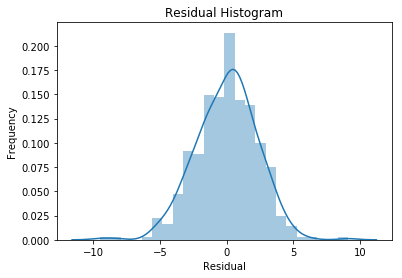

In [12]:
ols_model = sm.ols(formula = 'childHeight ~ father + mother + father_sqr + mother_sqr + 1', data=male_df)

results = ols_model.fit()
n_points = male_df.shape[0]
y_output = male_df['childHeight'].values.reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

It is clear from the summary that this model is over-parameterized. Only the intercept is significant. In other words, we are computing the average value of the label (childHeight), but nothing more. Examination of the residual plots shows them to be mostly well behaved, except with a bit of curvature in the standardized residual plot. 

### Apply Stepwise Regression

Stepwise regression using model performance metrics to prune the number of features in a model. The steps can be forward, wherein features are added one at a time in order of importance, until a point of diminished return is reached. Or, the steps can be backward, wherein a model using all features is pruned one feature at a time in reverse order of importance. It is also possible to step in both directions. In practice, either backward steps or using both directions are used, since forward steps have a tendency to get stuck at poor solutions. 

A significant issue with stepwise regression is to choose a performance metric. Many commonly used error metrics like RMSE will naturally get better as we add more model parameters. Consequently the **Akaike information criterion** (AIC) is often used. We can write the AIC as:

$$AIC = 2 k - 2 ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parameters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
k = number\ of\ model\ parameters$$

In words, the AIC is the model log-likelihood adjusted for the number of model parameters. The objective is to minimize the AIC. 

The quantity $- 2 ln(p(x| \hat\theta))$ is sometimes referred to as the **deviance** of the model. Deviance is a measure of the relative likelihood of the model. Deviance is a generalization of the variance. In fact, deviance should be measured with respect to a saturated model (number of parameters = number of observations), but this step is often skipped.

In [13]:
def forward_selected(data, response):
    """Linear model designed by forward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
    """
    # Start with no factors (intercept only)
    formula = "{} ~ 1".format(response)
    best_aic = sm.ols(formula, data).fit().aic
    
    # Go through remaining sets of variables one-by-one
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_aic = best_aic
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while remaining and current_aic == best_aic:
        aic_candidates = []
        for candidate in remaining:
            # Try adding the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            # Append tuple of the form (aic, response)
            aic_candidates.append((aic, candidate))
        # Sort all the pairs by the first entry of tuple (default of sort() method)
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        # Now check if we have something better:
        if best_new_aic < current_aic:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_aic = best_new_aic
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    # Get the model object
    model = sm.ols(formula, data).fit()
    return model

model = forward_selected(male_df, 'childHeight')

print(model.model.formula)

print('Adjusted-R-Squared: {0:.3f}'.format(model.rsquared_adj))
print('AIC: {0:.3f}'.format(model.aic))

childHeight ~ father + 1
Adjusted-R-Squared: 0.151
AIC: 2145.184


## Your Turn 1

## Backward Stepwise Selection

Backward stepwise selection is a very similar algorithm.  Fill in the blanks in the following formula for backward stepwise selection:

In [14]:
def backward_selected(data, response):
    """Linear model designed by backward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
    """
    # Start with all factors and intercept
    possible_factors = set(data.columns)
    possible_factors.remove(response)
    formula = "{} ~ {} + 1".format(response, ' + '.join(possible_factors))
    
    # Fill out this formula!
    #--------------------------------
    # Fill in spot #1!!!!
    best_aic = sm.ols(formula, data).fit().aic                  # fill in spot 1, replace ???
    #--------------------------------
    
    current_aic = best_aic
    
    # Set a non-empty set of columns that will be labeled as "to remove and try"
    to_try_remove = possible_factors
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while to_try_remove and current_aic == best_aic:
        aic_candidates = []
        for candidate in to_try_remove:
            
            columns = possible_factors - set([candidate])
            # Try removing the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(columns))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            
            # Append tuple of the form (aic, response)
            aic_candidates.append((aic, candidate))
            
        # Sort all the pairs by the first entry of tuple (default of sort() method).
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        
        # Now check if we have something better:
        if best_new_aic < current_aic:
            # Remove the best candidate's name from possible_factors
            
            #--------------------------------
            # Fill in spot #2 & #3!!!!
            possible_factors.remove(best_candidate)          #fill in spot 2, replace ???
            current_aic = best_new_aic                     #fill in spot 3, replace ???
            #--------------------------------
            
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(possible_factors))
    # Get the model object
    model = sm.ols(formula, data).fit()
    return model

backwards_model = backward_selected(male_df, 'childHeight')

print(backwards_model.model.formula)

print('Adjusted R-Squared: {}'.format(backwards_model.rsquared_adj))
print('AIC: {}'.format(backwards_model.aic))

childHeight ~ mother_sqr + mother + father + 1
Adjusted R-Squared: 0.23559962008335011
AIC: 2098.5255363191977


## Linear Model Statistics
Now that we have a backwards-selected formula : `childHeight ~ father + mother + mother_sqr + 1`, let's use that formula to get the statistics of the model.

Intercept, Slopes : 
Intercept     69.228817
father         0.940834
mother        -2.256549
mother_sqr     3.035847
dtype: float64
Intercept t-value, Slope t-values: 
Intercept     648.834608
father          8.748704
mother         -0.538971
mother_sqr      0.724975
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept     0.000000e+00
father        4.083633e-17
mother        5.901674e-01
mother_sqr    4.688354e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 772.9413135437512
SST: 3213.3338494623654
SSR: 2440.392535918614
RMSE: 16.051389488595177
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     48.67
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           2.42e-27
Time: 

Text(0.5, 1.0, 'Residual Histogram')

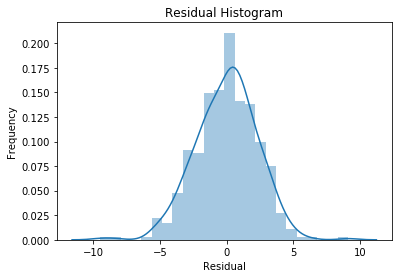

In [15]:
# Linear model stats
ols_model_forward = sm.ols(formula = 'childHeight ~ father + mother + mother_sqr + 1', data=male_df)

results = ols_model_forward.fit()
n_points = male_df.shape[0]
y_output = male_df['childHeight'].values.reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals:
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

### Adding an Interaction Term

We will try one last idea, adding an interaction term. In this case we will compute all possible interactions between the heights of the mother and the father, `mother`, `father`, and the interaction term: `mother X father`. 

Execute the code in the cell below to compute the model and print and plot the results. 

Intercept, Slopes : 
Intercept        69.223885
father            0.944032
mother            0.775070
mother:father     0.046383
dtype: float64
Intercept t-value, Slope t-values: 
Intercept        645.538364
father             8.788367
mother             7.210669
mother:father      0.475625
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept        0.000000e+00
father           3.019678e-17
mother           2.297275e-12
mother:father    6.345668e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 771.3573224714096
SST: 3213.3338494623654
SSR: 2441.976526990956
RMSE: 16.034933972126915
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     48.54
Date:                Mon, 18 Feb 2019   Prob (F-s

Text(0.5, 1.0, 'Residual Histogram')

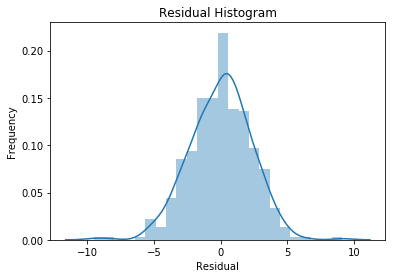

In [16]:
# Linear model stats
ols_model_forward = sm.ols(formula = 'childHeight ~ father + mother + mother*father + 1', data=male_df)

results = ols_model_forward.fit()
n_points = male_df.shape[0]
y_output = male_df['childHeight'].values.reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

It is clear from the summary that the interaction term is not significant. The best model we have to this point is the one computed with stepwise regression. 

***
**Note:** Stepwise regression appears to be a simple method for feature selection. However, be aware that **stepwise regression does not scale well**. As with any multiple comparison method, stepwise regression suffers from a high probability of false positive results. In this case, a feature which should be dropped might not be, because of a low p-value or AIC. 
***

## Regularization: Singular Value Decomposition

Now that we have explored both manual features of selection and stepwise regression, we will examine regularization methods. Regularization methods stabilize the inverse of the **model matrix**. In this section we will use the singular value decomposition method to stabilize a model matrix. 

You may well wonder why we need regularization methods, when we have tools like stepwise regression. Two important reasons are:

- Stepwise regression is a computationally intensive process, since we must recompute the model many times. There are methods that allow computation of the updated model, but with a large number of features there are numerous permutations. We need methods that can handle hundreds, thousands, or even millions of features.

> Note: Consider a small data set with only 20 features.  The amount of possible linear models with NO interaction terms is given by:  $\binom{20}{1} + \binom{20}{2} + \binom{20}{3} + \dots + \binom{20}{20}$, which is the sum of the 21st row of the Pascal's triangle.  This comes out to be $2^{20} = 1,048,576$.  Although, according to our algorithm, this would be the maximum number of models to compute, you can see how computationally hard this becomes.

- With stepwise regression a feature is either in or out of the model. This may not be the best choice. Perhaps a re-weighing the features in some way might be better. 
- Stepwise regression suffers from issues inherent in multiple comparisons. 

In order to understand the motivation and methods of feature selection/transformation, we will start with reviewing some linear algebra.

### Linear Algebra Review

Before we get into the details of regularization, let's review some basic linear algebra.

For this part of the notebook we will be using the library `numpy`, which is the numerical python library.

> Note: In python there are a few distinctions to make.  The base python has a variable type called 'Lists'. Lists are just that. They are lists of objects. `[5, 'foobar', True, ...]`. While we can make a list that contains all numbers: `[2.0, 2.0, 2.0]`, this is not a vector nor matrix. The package `numpy` introduces arrays (vectors and matrices) which have the correct associated matrix properties.

> Note: Please be careful using Jupyter Notebook. Jupyter displays arrays the same way as it does lists (you'll see in examples below).  It is even the case that some numpy functions and objects will interact with lists the same way, but sometimes they do not and it can be frustrating to troubleshoot if they appear the same way.  Always read documentation and check the types of your variables with the command `type(my_variable)`.

Let's start by creating two vectors of length 3.

In [17]:
a_list = [2]*3
print(a_list)
print(type(a_list))
a = np.array([2]*3)
print(a)
print(type(a))
b = np.arange(1, 4)
print(b)
print(type(b))

[2, 2, 2]
<class 'list'>
[2 2 2]
<class 'numpy.ndarray'>
[1 2 3]
<class 'numpy.ndarray'>


### Element-wise Operations
We can perform some basic element-wise arithmetic operations on vectors.

In [18]:
print(a + b)
print(a * b)

[3 4 5]
[2 4 6]


These vectors are both dimension (size) three.

We can do the same in two-dimensional matrices as follows:

In [19]:
a2d = np.array([[2]*3, [3]*3])
print('a: \n{} \n a-size: {}'.format(a2d, a2d.shape))
b2d = np.reshape(np.arange(1,7), newshape=(2, 3))
print('\nb: \n{} \n b-size: {}'.format(b2d, b2d.shape))

# Addition
print('\nAddition: \n {}'.format(a2d + b2d))
# Multiplication
print('\nMultiplication: \n {}'.format(a2d * b2d))

a: 
[[2 2 2]
 [3 3 3]] 
 a-size: (2, 3)

b: 
[[1 2 3]
 [4 5 6]] 
 b-size: (2, 3)

Addition: 
 [[3 4 5]
 [7 8 9]]

Multiplication: 
 [[ 2  4  6]
 [12 15 18]]


### Transposing a Matrix
We can also _transpose_ a two-dimensional matrix by flipping the rows and columns. We use the `numpy` method `np.transpose`.

In [20]:
print('Try transposing on a vector...')
print(np.transpose(a))
# Uh oh!  Transpose on a vector doesn't do anything...

print('Now reshape a into 2D and then transpose:')
print(np.transpose(np.reshape(a, newshape=(1,3))))
print('Now transpose a 2d matrix:')
print(np.transpose(a2d))

Try transposing on a vector...
[2 2 2]
Now reshape a into 2D and then transpose:
[[2]
 [2]
 [2]]
Now transpose a 2d matrix:
[[2 3]
 [2 3]
 [2 3]]


### Matrix Dot Product
We can also compute the **dot product**, which is also known as the **scalar product** or **inner product** of two vectors of equal length.

$$dot\ product = \Sigma_i^n a_i \cdot b_i$$

Give the dot product a try by executing the code in the cell below. We use the `numpy` method `np.dot`.

In [21]:
print('np.dot(a, b) = np.dot({}, {})'.format(a, b))
np.dot(a, b)

np.dot(a, b) = np.dot([2 2 2], [1 2 3])


12

The square root of the inner product of a vector with itself is the length or $L2$ norm of the vector.

$$\parallel a \parallel = length\ of\ vector\ a = \sqrt{a \cdot a}$$

--------------------

## Your Turn 2

Create and execute the code to compute the length or norm of the vector `a` in the cell below.

In [22]:
def inner_prod(vec1, vec2):
    # Replace the ??? in the following calculation:
    inner_prod_calc = np.dot(vec1, vec2)
    return inner_prod_calc

def l2_norm(my_vec):
    # Replace the ??? in the following calculation:
    l2_norm_calc = np.sqrt(np.dot(my_vec, my_vec))
    return l2_norm_calc

print('L2 Norm of {} = {}'.format(a, l2_norm(a)))
# Should get ~3.4641016151377544

L2 Norm of [2 2 2] = 3.4641016151377544


In [116]:
# alternative code
def inner_prod(vec1, vec2):
    # Replace the ??? in the following calculation:
    inner_prod_calc = np.dot(vec1, vec2)
    return inner_prod_calc

def l2_norm(my_vec):
    # Replace the ??? in the following calculation:
#     l2_norm_calc = np.sqrt(np.dot(my_vec, my_vec))
    l2_norm_calc = np.sqrt(inner_prod(my_vec, my_vec))
    return l2_norm_calc

print('L2 Norm of {} = {}'.format(a, l2_norm(a)))
# Should get ~3.4641016151377544

L2 Norm of [2 2 2] = 3.4641016151377544


We can also write the inner product as:

$$a \cdot b = \parallel a \parallel \parallel b \parallel cos(\theta)\\
or \\
cos(\theta) = \frac{a \cdot b}{\parallel a \parallel \parallel b \parallel}$$

Notice that the inner product of orthogonal vectors is $0$. Run the code in the cell below to see an example.

In [23]:
aa = np.array([1, 0, 0])
bb = np.array([0, 1, 1])
print(inner_prod(aa, bb))

0


Let's try some operations on matrices. Let $A$ and $B$ be $m = 4$ rows by $n = 3$ columns matrices. 

In [24]:
A = np.array([[4]*3]*4) # A has 4 rows and 3 columns
print(A)
B = np.array(np.reshape(np.arange(1, 13), newshape = (4, 3)))
print(B)

[[4 4 4]
 [4 4 4]
 [4 4 4]
 [4 4 4]]
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


We can perform some arithmetic operations element by element on these matrices.

In [25]:
print(A + B)
print(A * B)

[[ 5  6  7]
 [ 8  9 10]
 [11 12 13]
 [14 15 16]]
[[ 4  8 12]
 [16 20 24]
 [28 32 36]
 [40 44 48]]


We can multiply a $mxn$ matrix by a vector of length $n$ by taking the inner product of each row of the matrix and the vector. The result in a vector of length $n$. Each element of the result can be written at:

$$y_i = \Sigma_j^m A_{ij} \cdot b_j$$

Run the code in the cell below and examine the result. 

In [34]:
print(A.shape)
print(b.shape)
b

(4, 3)
(3,)


array([1, 2, 3])

In [26]:
np.dot(A, b)

array([24, 24, 24, 24])

In [35]:
np.dot(A, b).shape

(4,)

So, how do we multiply two matrices? In matrix multiplication each element of the resulting matrix is the inner product of a row by a column. For example, the element $Y_{ij}$ of the result matrix is computed as follows:

$$Y_{ij} = \Sigma_j^m A_{ij} \cdot B_{ji}$$

Notice that the number of columns, $m$, of the first matrix must equal the number of rows of second matrix. And, that the number of rows, $n$ of the first matrix must equal the number of columns of the second matrix. In this case, the two matrices are said to be **conformable**. 

Give matrix multiplication a try by executing the code in the cell below.

In [31]:
# np.dot(A, B)

ValueError: shapes (4,3) and (4,3) not aligned: 3 (dim 1) != 4 (dim 0)

That operation failed! Evidently these matrices are not conformable. 

But, what if we take the transpose of $B$? The **transpose** of a matrix is just that matrix with the row and column indices permuted like this:

$$B_{ji}^T = B_{ij}\\
where \\
B\ has\ dimensions\ n x m \\
and \\
B^T\ has\ dimensions\ m x n$$ 

If we multiply an $n x m$ matix by an $m x n$ matrix the result is a square $n x n$ matrix. 

We can execute the code in the cell below to multiply the matrix A by the transpose of B. Use the np.transpose() function to take the transpose of the matrix:

In [32]:
AtB = np.dot(np.transpose(A), B)
print('A\'*B = \n{}'.format(AtB))
print('Shape of A\'*B = {}'.format(AtB.shape))

ABt = np.dot(A, np.transpose(B))
print('\nA*B\' = \n{}'.format(ABt))
print('Shape of A*B\' = {}'.format(ABt.shape))

A'*B = 
[[ 88 104 120]
 [ 88 104 120]
 [ 88 104 120]]
Shape of A'*B = (3, 3)

A*B' = 
[[ 24  60  96 132]
 [ 24  60  96 132]
 [ 24  60  96 132]
 [ 24  60  96 132]]
Shape of A*B' = (4, 4)


### Identity Matrix
We can define the **identity** matrix having ones on the diagonal and zeros elsewhere.

$$I = \begin{bmatrix}
    1  & 0 & 0 & \dots & 0 \\
    0  & 1 & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & 1
\end{bmatrix}$$

The identity multiplied by any matrix gives that matrix. If $AB$ is a rectangular matrix then:

$$AB = I \cdot AB = AB \cdot I$$

In `numpy` the Identity matrix is called `np.eye` and takes as an argument the number of rows/columns.

In [36]:
I3 = np.eye(3)
I4 = np.eye(4)

print('I (3X3) = \n{}'.format(I3))

print(np.dot(I3, AtB))
print(np.dot(I4, ABt))

I (3X3) = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 88. 104. 120.]
 [ 88. 104. 120.]
 [ 88. 104. 120.]]
[[ 24.  60.  96. 132.]
 [ 24.  60.  96. 132.]
 [ 24.  60.  96. 132.]
 [ 24.  60.  96. 132.]]


### Inverse of a Matrix
In principle we can compute an inverse of a matrix so that:

$$A = A\\
A = AI \\
A^{-1}A = I$$

Use the Linear Algebra methods in `numpy` to get the inverse of matrix $M$ with `np.linalg.inv`.

In [38]:
np.set_printoptions(suppress=True)  # Suppress scientific notation when printing
M = np.array([[1., 4.], [-3., 2.]])
M_inverse = np.linalg.inv(M)

print('M: \n{}'.format(M))

print('\nM_inv = \n{}'.format(M_inverse))

print('\nM_inv * M = \n{}'.format(np.dot(M_inverse, M)))

print('\nM * M_inv = \n{}'.format(np.dot(M, M_inverse)))

M: 
[[ 1.  4.]
 [-3.  2.]]

M_inv = 
[[ 0.14285714 -0.28571429]
 [ 0.21428571  0.07142857]]

M_inv * M = 
[[ 1. -0.]
 [ 0.  1.]]

M * M_inv = 
[[ 1. -0.]
 [ 0.  1.]]


## Singular Value Decomposition
In machine learning, we often encounter matrices which cannot be inverted directly. Instead, we need a decomposition of $A$ that allows us to compute $A^{-1}$. One possibility is a method called singular value decomposition or SVD:

$$svd(A) = U D V^{\ast}$$

Where,

- $U$ are the orthogonal unit norm left singular vectors.
- $V$ are the orthogonal unit norm right singular vectors, and $V^{\ast}$ is the conjugate transpose. For real-valued $A$ this is just $V^T$.
- $D$ is a diagonal matrix of singular values, which are said to define a **spectrum**.
- $A$ is comprised of the linear combination of singular vectors scaled by singular values.

To compute the SVD of a matrix and view the results execute the code in the cell below. We use the `numpy` method called `np.linalg.svd` using `s` for the singular values.

In [39]:
U, s, V = np.linalg.svd(B, full_matrices=False)
print('U: {}'.format(U))
print('s: {}'.format(s))
print('V: {}'.format(V))

U: [[-0.14087668  0.82471435  0.53358462]
 [-0.34394629  0.42626394 -0.8036038 ]
 [-0.54701591  0.02781353  0.00645373]
 [-0.75008553 -0.37063688  0.26356544]]
s: [25.46240744  1.29066168  0.        ]
V: [[-0.50453315 -0.5745157  -0.64449826]
 [-0.76077568 -0.05714052  0.64649464]
 [-0.40824829  0.81649658 -0.40824829]]


In [40]:
# It's called a factorization because...
# Create a diagonal matrix
S = np.diag(s)

# Matrix multiply:  U * S * V
B_reconstruction = np.dot(U, np.dot(S, V))
np.allclose(B, B_reconstruction)

True

----
Hint: check the values of S, B, and B_reconstruction
<hr>

In [43]:
B_reconstruction

array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]])

You can verify that the singular vectors form a orthonormal basis by checking to see if $U \cdot U^{T} = U^{T} \cdot U = I$ and $V \cdot V^{T} = V^{T} \cdot V = I$. We can check this by executing the code in the cell below:

In [44]:
basis_vec_check1 = np.dot(np.transpose(U), U)
print(np.round(basis_vec_check1, 2))

basis_vec_check2 = np.dot(V, np.transpose(V))
print(np.round(basis_vec_check2, 2))

[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]


The result are two identity matrices!

We can view the product of the matrix $A$ with a vector as defining a rotation and scaling. The singular value decomposition of $A$ can be viewed as:

- A first rotation defined by the unit norm singular values $V^{\ast}$.
- A scaling defined by the diagonal singular value matrix $D$.
- A second rotation defined by the unit norm singular values $U$.

This geometric interpretation can be visualized as shown in the figure below.

<img src="https://library.startlearninglabs.uw.edu/DATASCI410/img/SVD.png" title="Singular Value Decomposition" style="height: 300px;">

Execute the code in the cell below and examine the rotations and scaling of the initial vector.

In [45]:
# 2-Dimensional Example
D = np.array([[3., 4.], [1., 5.]])
U, s, V = np.linalg.svd(D, full_matrices=False)
e = np.sqrt(1./2.)
u = np.array([e, e])

print('u: {}'.format(u))
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u), u))))
print('\n')

print('First Rotation:')
u_rot1 = np.dot(np.transpose(V), u)
print(u_rot1)
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u_rot1), u_rot1))))
print('\n')

print('Scaling:')
u_scaled = np.dot(np.diag(s), u_rot1)
print(u_scaled)
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u_scaled), u_scaled))))
print('\n')

print('Second Rotation:')
u_rot2 = np.dot(U, u_scaled)
print(u_rot2)
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u_rot2), u_rot2))))

# ---------------
# Check with just D * u
print('\n')
print('Originally, D * u = {}'.format(np.dot(D, u)))

u: [0.70710678 0.70710678]
Magnitude: 1.0


First Rotation:
[0.932458   0.36127839]
Magnitude: 0.9999999999999997


Scaling:
[6.49418233 0.57061013]
Magnitude: 6.519202405202648


Second Rotation:
[4.94974747 4.24264069]
Magnitude: 6.519202405202649


Originally, D * u = [4.94974747 4.24264069]


## Your Turn 3:
Compute the SVD of matrix $B$ and do the following:
- Demonstrate that the 4X3 matrix $B$ gives the same rotation and scale by multiplying a vector `u = np.array([e, e, e])` where `e = np.sqrt(1./3.)` as multiplying the decomposition, $U \cdot S \cdot V' = B$  by `u`.

In [46]:
B

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [47]:
# Get SVD decomposition
U, s, V = np.linalg.svd(B, full_matrices=False)
S = np.diag(s)

# Setup a 3-D rotational vector.
e = np.sqrt(1./3.)
u = np.array([e, e, e])

# Replace the ???
# Calculate Rotation:
# u_rot = V' * u
u_rot = np.dot(np.transpose(V), u)
print('\nRotation: {}'.format(u_rot))

# Calculate Scaling:
# u_scaled = diag(s) * u_rot
u_scaled = np.dot(S, u_rot)
print('\nScaled: {}'.format(u_scaled))

# Calculate the last rotation:
# u_rot2 = U * u_scaled
u_rot2 = np.dot(U, u_scaled)
print('\nRotation 2: {}'.format(u_rot2))

#------ Are they the same? Calculate just B*u --------

# Calculate r = B * u:
r = np.dot(B, u)
print('\nr = B * u = {}'.format(r))


Rotation: [-0.96622865  0.10671763 -0.23454965]

Scaled: [-24.60250763   0.13773636  -0.        ]

Rotation 2: [ 3.57951266  8.52065337 13.46179408 18.40293478]

r = B * u = [ 3.46410162  8.66025404 13.85640646 19.05255888]


## Pseudo Inverse
We will be interested in the inverse of a matrix A to solve linear regression.  If a matrix, $A$ has a SVD decomposition, $U \cdot S \cdot V'$, then the inverse, $A^{-1}$ can be calculated as follows:

$$ A^{-1} = \left( U \cdot S \cdot V'  \right)^{-1} $$

$$ = V'^{-1} \cdot S^{-1} \cdot U^{-1} $$

From before, we know (and you can verify with numpy operations) that the inverse of the matrices $V$ and $U$ are transposes. I.e, $U^{-1} = U'$ and $V^{-1}=V'$.  Also, remember that $S$ is a diagonal matrix, with zero values off the diagonal. The inverse of $S$ is easy to calculate:

If,

$$
S = \textrm{diag}(s_{1}, s_{2}, ...)
$$

Then,

$$
S^{-1} = \textrm{diag}\left( \frac{1}{s_{1}}, \frac{1}{s_{2}} , ... \right)
$$

We end up with:

$$ A^{-1} = V \cdot S^{-1} \cdot U' $$

This representation of $A^{-1}$ is called the **pseudo inverse** also known as the **Moore-Penrose inverse**.

It is commonly written as:

$$A^\dagger = V \cdot D^+ \cdot U'$$

Where,

- $D^+$ is the square diagonal matrix of **inverse singular values** significantly greater than $0$. All other terms are set to $0$.
- $U'$ is the transpose of the right singular value matrix. 
- $V$ is the left singular value matrix.

The matrix, $A$ may not be of full rank. The types of long and narrow $n x m$ matrices we encounter in machine learning are typically **rank deficient**. A rank deficient matrix arises when there is linear dependency between one or more of the columns. As an example, a matrix with correlated (not necessarily perfectly correlated) columns is bound to be rank deficient. 

A matrix is considered rank deficient if it has one or more of the $m$ singular values  $d_i  \sim 0.0$. In this case we substitute $0.0$ values on the diagonal of $D^+$ where the singular values $d_i \sim 0.0$. In fact, we want $d_i$ to be significantly greater than $0$. 

Let's try an example. The code in the cell below computes the SVD of a matrix of random numbers chosen from a Normal distribution. The pseudo inverse is computed and multiplied by the original matrix. Execute this code and note the result.

In [54]:
print('Create a matrix of random normal values:')
C = np.array(np.random.randn(3, 3))
print(C)

print('\nCompute the SVD and look at the singular values:')
U, s, V = np.linalg.svd(C, full_matrices=False)
print(s)

print('\nThe inverse matix of singular values:')
D = np.diag(np.reciprocal(s))
print(D)

print('\nThe Pseudo-inverse of the matrix:')
cInv = np.dot(np.dot(np.transpose(V), D), np.transpose(U))
print(cInv)

print('\bThe Pseudo-inverse times the matrix:')
out = np.dot(cInv, C)
print(np.round(out, 2))

Create a matrix of random normal values:
[[ 0.81083402 -1.02511048  2.43355697]
 [ 0.2381437  -1.01939447 -0.61421798]
 [ 0.51966459 -0.38855442 -0.15173106]]

Compute the SVD and look at the singular values:
[2.76881963 1.3261446  0.35024353]

The inverse matix of singular values:
[[0.36116473 0.         0.        ]
 [0.         0.75406558 0.        ]
 [0.         0.         2.85515623]]

The Pseudo-inverse of the matrix:
[[-0.06530363 -0.85619996  2.41857738]
 [-0.22009639 -1.07901643  0.83789161]
 [ 0.33996627 -0.16924814 -0.45288989]]
The Pseudo-inverse times the matrix:
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]


First, notice that the singular values are of similar magnitude and none are near zero. This matrix is not rank deficient. 

### Pseudo Inverse Example
Let's try another example. The code in the cell below does the following:

- Creates a $4 X 4$ matrix of numbers drawn from a Normal distribution.
- Substitutes values in the 4th column which are a linear combination of the other three columns.
- Computes the SVD of this matrix.
- Creates the inverse diagonal matrix of singular values.
- Computes the pseudo inverse of the matrix.
- Multiplies the pseudo inverse by the original matrix. 

Execute this code and examine the result.

In [55]:
print('Create a matrix of random normal values:')
C = np.array(np.random.randn(4, 4))
# Rewrite the 4th column as a linear combination of the prior 3 columns
C[:, 3] = 0.4 * C[:, 0] + 0.2 * C[:, 1] + 0.4 * C[:, 2]
print(C)

print('\nCompute the SVD and look at the singular values:')
U, s, V = np.linalg.svd(C, full_matrices=False)
print(s)

print('\nThe inverse matix of singular values:')
D = np.diag(np.reciprocal(s))
print(D)

print('\nThe Pseudo-inverse of the matrix:')
cInv = np.dot(np.dot(np.transpose(V), D), np.transpose(U))
print(cInv)

print('\bThe Pseudo-inverse times the matrix:')
out = np.dot(cInv, C)
print(np.round(out, 2))

Create a matrix of random normal values:
[[-0.54551298 -1.50788857 -0.80932648 -0.8435135 ]
 [-1.28027793  1.66459989 -1.91909918 -0.94683086]
 [ 0.87056479 -0.65878519 -0.44397361  0.03887943]
 [-0.53753928 -0.50469898  2.71361914  0.76949214]]

Compute the SVD and look at the singular values:
[3.88301699 2.26123899 1.62057717 0.        ]

The inverse matix of singular values:
[[2.57531709e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.42235431e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.17064104e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.37244041e+15]]

The Pseudo-inverse of the matrix:
[[-5.33982185e+13  4.68511617e+14  9.45852057e+14  4.70160681e+14]
 [-2.66991092e+13  2.34255808e+14  4.72926029e+14  2.35080341e+14]
 [-5.33982185e+13  4.68511617e+14  9.45852057e+14  4.70160681e+14]
 [ 1.33495546e+14 -1.17127904e+15 -2.36463014e+15 -1.17540170e+15]]
The Pseudo-inverse times the matrix:
[[ 1.   -0.25 -0.19  0.2

Notice the following about this result:

- The 4th singular value is nearly zero. Evidently, this matrix is rank deficient. 
- The product of the pseudo inverse is not close to being the identity matrix. This is the result of taking using the unstable inverse of the rank deficient matrix.

Instead, let's set the singular value that is near zero to actually zero.

- Set the inverse of the smallest singular value to zero.
- Compute the pseudo inverse.
- Compute the product of the pseudo inverse and the original matrix. 
- Note if the result is closer to an identity matrix. 

In [56]:
print('The inverse matrix of singular values:')
print(D)

# Fill in the missing spots
print('\nSet the near-zero singular values to zero:')
D[3, 3] = 0.0
print(D)

print('\nThe pseudo-inverse of the matrix:')
cInv = np.dot(np.dot(np.transpose(V), D), np.transpose(U))
print(cInv)

print('\nThe pseudo-inverse times the matrix:')
out = np.dot(cInv, C)
print(out)

The inverse matrix of singular values:
[[2.57531709e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.42235431e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.17064104e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.37244041e+15]]

Set the near-zero singular values to zero:
[[0.25753171 0.         0.         0.        ]
 [0.         0.44223543 0.         0.        ]
 [0.         0.         0.6170641  0.        ]
 [0.         0.         0.         0.        ]]

The pseudo-inverse of the matrix:
[[-0.2837155  -0.27463579  0.25910331 -0.27980486]
 [-0.40323864  0.17141305 -0.09005029 -0.03544954]
 [-0.06218104 -0.05546709 -0.10075272  0.25090101]
 [-0.21900634 -0.09775854  0.04533018 -0.01865145]]

The pseudo-inverse times the matrix:
[[ 0.88235294 -0.05882353 -0.11764706  0.29411765]
 [-0.05882353  0.97058824 -0.05882353  0.14705882]
 [-0.11764706 -0.05882353  0.88235294  0.29411765]
 [ 0.29411765  0.14705882  0.29411765  0.264

### Regression with the Pseudo Inverse

We have already looked at feature selection using manual trial and error methods and stepwise regression. How can we use the pseudo inverse to create a regularized regression? 

Let's start by examining the linear regression problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ amd a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

However, this is hard to do directly in practice.

- In typical case $A$ is long and narrow. In other words we have more data **cases** than coeficients. 
- Solving for $A^{-1}$ is computationally difficult and inefficient.
- Solution is numerically unstable if $A$ is rank deficient. 

One way to deal with the problem of rank deficiency is to use the pseudo inverse $A^\dagger$. Recalling the singular value decomposition of $A$ we can write:

$$A^\dagger = V D^+ U^*$$

***
**Note:** In practice, the direct computation of a pseudo inverse is rarely used for linear models. Instead, more computationally efficient methods such as QR decomposition are often used. Discussion of these methods is beyond the scope of this course. Details can be found in many sources including the seminal book titled [Matrix Computations](http://web.mit.edu/ehliu/Public/sclark/Golub%20G.H.,%20Van%20Loan%20C.F.-%20Matrix%20Computations.pdf) by Gene Golub and Charles van Loan.
***

As a first step we need to create a model matrix of the features for the Galton height data. Execute the code in the cell below which creates a matrix from the features in a data frame.

In [57]:
male_df_vars = male_df.loc[:,['mother', 'father','mother_sqr', 'father_sqr']]
M = male_df_vars.as_matrix()
childHeight = male_df.loc[:,'childHeight']

print('1st 5 rows of Data Frame: ')
print(male_df_vars.head())
print('\n1st 5 rows in matrix Form: ')
print(M[0:5, :])
# FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.

1st 5 rows of Data Frame: 
     mother    father  mother_sqr  father_sqr
0  1.284365  4.061811    1.302257    4.309762
1  1.069935  2.756018    1.077586    2.859293
2  1.069935  2.756018    1.077586    2.859293
3 -0.002213  2.538386   -0.020524    2.623043
4 -0.002213  2.538386   -0.020524    2.623043

1st 5 rows in matrix Form: 
[[ 1.2843648   4.06181124  1.3022572   4.30976174]
 [ 1.06993509  2.75601845  1.07758629  2.85929319]
 [ 1.06993509  2.75601845  1.07758629  2.85929319]
 [-0.00221347  2.53838631 -0.02052434  2.62304263]
 [-0.00221347  2.53838631 -0.02052434  2.62304263]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


The next step is to compute the SVD of the resulting matrix and examine the singular values. In the cell below, execute code to do the following:
1. We will use numpy's built in function, `np.linalg.lstsq` to perform linear regression via the SVD.
2. We extract the beta coefficients.
3. From these coefficients, we perform the predictions.
4. We will also compute the R-squared.

In [58]:
beta_coeffs, resids, rank, s = np.linalg.lstsq(M,childHeight)

print('beta coefficients: {}'.format(beta_coeffs))

print('\nsingular values: {}'.format(s))

beta coefficients: [-2.30368301  1.40603156  3.08328829 -0.46547106]

singular values: [32.09010631 28.80817858  0.41629955  0.37499153]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Notice that the 3rd and 4th singular values are a few orders of magnitude smaller than the first two. This matrix is most likely rank deficient.

### Model Evaluation
Now that we have a vector of model coefficients, its time to evaluate our model.  We use the following steps:

- Compute the predicted values or scores using the product of the model matrix and the model coefficients. We need to add the mean of the label values.
- Compute the residuals.
- Display residual plots and summary statistics.

Execute this code and examine the results. 

SSR: 2440.322615837603
SST: 3213.333849462365
R-squared = 0.24056362327683367


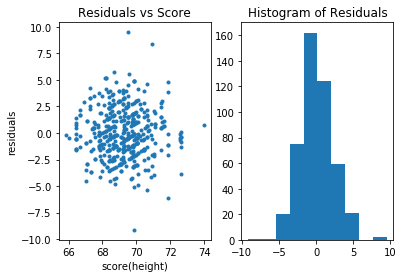

In [59]:
male_predictions = np.dot(M, beta_coeffs) + np.mean(childHeight)
male_resids = male_predictions - childHeight

# Plot the residuals vs score (height)
plt.subplot(1, 2, 1)
plt.plot(male_predictions, male_resids, '.')
plt.ylabel('residuals')
plt.xlabel('score(height)')
plt.title('Residuals vs Score')

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(male_resids)
plt.title('Histogram of Residuals')

# R-squared
#              SSR
# R^2 = 1 -  -------
#              SST

SSR = np.sum(np.square(male_resids))
SST = np.sum(np.square(childHeight - np.mean(childHeight)))

print('SSR: {}'.format(SSR))
print('SST: {}'.format(SST))

R2 = 1.0 - (SSR / SST)

print('R-squared = {}'.format(R2))


## Principal Component Regression

In various regression transformations we have applied, we haven't yet asked ourselves, "What is a good transformation to the independent features that may create an optimal amount of independence between them?"

Here, the idea is to combine the features into new wholly independent features by combining them in various linear fashions.

Imagine we are performing linear regression on multiple features (n of them), where our model is as follows:

$$
y_{i} = \beta_{0} + \beta_{1}x_{1} + ... + \beta_{n}x_{n} + \epsilon_{i}
$$

We might just proceed forward and assume that our x-features are independent and see how our model performs.  What if we could find new features such that they are guaranteed to be completely independent of each other as follows:

$$
y_{i} = \beta_{0} + \beta_{1}\cdot f_{1} \left( x_{1}, ... , x_{n} \right) + ... + \beta_{n}f_{n} \left( x_{1}, ... , x_{n} \right) + \epsilon_{i}
$$

Here, we are creating new features, which are linear combinations of all our prior x-features in our $f()$ functions.  If we write out what an $f()$ function might look like:

$$
f_{m} = a_{0} + a_{1} \cdot x_{1} + ... + a_{n} \cdot x_{n}
$$

The question still remains, how do we find such magical $f()$ functions that assures us that the new features, $f_{m}$ taken together are 100% independent of each other?

The method of finding these very important components is called Principal Component Analysis (or PCA).  Then when we use these component functions to do regression, it is called Principal Component Regression (or PCR).

It is considered a regularized regression because, typically, we end up with less features than we started with because, in reality, there is always some dependence in our data.

You can imagine that, depending on how much dependence is in our data, that the first components found will explain a majority of the variance in the response and the last components add very little explanatory power.  It is common to choose a smaller subset of PCA regressors to do PCR.

The benefits of PCR is that it assures us that our new features are completely independent, which overcomes the multicollinearity problem in regression.

The downside is that the new features, being functions of variables, are less interpretable than using the original features.

-----------------------
PCR has these steps (commonly):

--------------------------

0. Scale the input features in your data matrix!

1. Perform PCA on the observed data matrix to obtain the principal components.

2. Select a subset of the principal components for regression. Usually we select the components that explain the most of the variance in the dependent variable.

3. Perform linear regression using the selected principal components as features.


The reason we cover this regression method after introducing singular value decomposition is that the SVD is used to find the principal components of the data matrix.

For exploring this method, we use generated data to illustrate how components work on features that are not fully independent.

To compute PCR, we will use the PCA function from the `sklearn decomposition` library.

Text(0.5, 1.0, 'Generated x-y data with dependence')

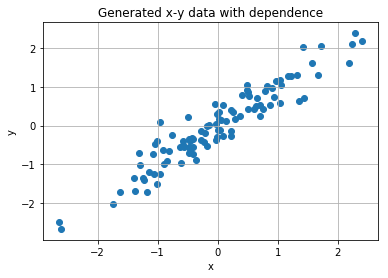

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(10)

# We right-multiply a 2x2 matrix to a 2x100 matrix to transform the points to be related.
X = np.dot(np.random.randn(100, 2), np.random.rand(2, 2))
# Scale the points
X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1])
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated x-y data with dependence')

Let's look at the first two principal components, because we can visualize 2 dimensions in a graph.

In [62]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(data = pca_result , columns = ['pc1', 'pc2'])

print(pca_df.head())
print(pca_df.shape)

        pc1       pc2
0 -1.861103 -0.019623
1  2.153868 -0.210132
2 -0.198147  0.209563
3 -0.192361 -0.015800
4  0.288416  0.014695
(100, 2)


Plot the output!

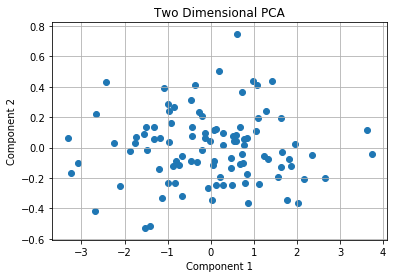

In [63]:
plt.scatter(pca_df.loc[:, 'pc1'], pca_df.loc[:, 'pc2'])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Two Dimensional PCA')
plt.grid()

We can also look at how much variance _in the original features_ we are explaining with each principal component.

In [64]:
print(pca.explained_variance_)
print(pca.components_)

[1.96728837 0.05291365]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


How do we interpret the above variances and components?

For the "explained variance" we interpret those values as the variance of the dataset when all the data is projected onto that $f()$ function axis.  So here, the first $f()$ function (or principal component) explains 1.95 units of the variance. The second component explains the remaining 0.05 units of variance.

For the components, this tells us the direction of the principal components. In fact, all principal components (i.e. rows) in this matrix have the property that the magnitude of them is exactly 1.  Here, $\sqrt{(-0.707...)^{2} + (-0.707...)^{2}} = 1$.

The combination of these two matrices (explained variance and component direction) tells us that we can plot these vectors amongst the original data to see them.

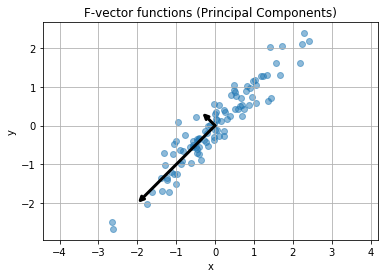

In [65]:
exp_var = pca.explained_variance_
components = pca.components_

# Vector to plot
#    = plot scale * component direction * component length
v1 = 2 * components[0] * np.sqrt(exp_var[0])
v2 = 2 * components[1] * np.sqrt(exp_var[1])
c = (0, 0) # Center is at 0,0 because of our standardization

plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.annotate('', c + v1, c, arrowprops={'arrowstyle': '->', 'shrinkA': 0,
                                        'shrinkB': 0, 'linewidth': 3})
plt.annotate('', c + v2, c, arrowprops={'arrowstyle': '->', 'shrinkA': 0,
                                        'shrinkB': 0, 'linewidth': 3})
plt.axis('equal')
plt.grid()
plt.title('F-vector functions (Principal Components)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### What Now?


From the above plot, we can see that the two vectors we've plotted are completely independent of each other. In other words, they are perpendicular!

We can extend this to higher dimensional data and it has many uses:

- If we have very high dimensions, we can reduce the number of dimensions needed for a good regression fit.

- Calculating the Principal Components removes any multi-collinearity issues in the data.

- We can project the original data points onto our principal component axes and perform regression.

We will combine everything we've learned into a principal component linear regression with actual data below. (Galton height data for females this time)

## Your Turn 4:

If our Galton height data set has 4 features, how many principal components will there be?


Let us compute all the principal components for our Galton height data on the female data points.

In [66]:
# Subset the data with a Boolean Flag
isFemale = family_data.loc[:,"gender"] == "F"

# Create just the female dataframe
female_data = family_data[isFemale].copy()

In [67]:
# Create new data frame for new feature set
female_df = female_data.copy()

# Add in squares of mother and father heights
female_df['father_sqr'] = female_df['father'] **2
female_df['mother_sqr'] = female_df['mother'] **2

# Drop columns for family, gender, kids
Obsolete = ["family", "gender", "kids"]
for x in Obsolete:
    female_df = female_df.drop(x, axis=1)
    
# Reset the index
female_df=female_df.reset_index(drop=True)

# Add scaled x to data frame
female_df['father'] = scale(female_df['father'])
female_df['mother'] = scale(female_df['mother'])
female_df['father_sqr'] = scale(female_df['father_sqr'])
female_df['mother_sqr'] = scale(female_df['mother_sqr'])

# preview the data
female_df.head()

,father,mother,childHeight,father_sqr,mother_sqr
0,3.485498,1.244505,69.2,3.684456,1.261392
1,3.485498,1.244505,69.0,3.684456,1.261392
2,3.485498,1.244505,69.0,3.684456,1.261392
3,2.348637,1.024665,65.5,2.425862,1.031406
4,2.348637,1.024665,65.5,2.425862,1.031406


In [68]:
# Calculate all the Principal components
X = female_df.as_matrix(columns=['father', 'mother', 'father_sqr', 'mother_sqr'])
y = female_df['childHeight']
pca = PCA()
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(data = pca_result, columns=['pc1', 'pc2', 'pc3', 'pc4'])

# Here is our data projected onto the four principal components.
print(pca_df.head())
print(pca_df.shape)

pca_df['childHeight'] = female_df['childHeight']

        pc1       pc2       pc3       pc4
0  4.837356  2.333312  0.138364 -0.017713
1  4.837356  2.333312  0.138364 -0.017713
2  4.837356  2.333312  0.138364 -0.017713
3  3.414935  1.360147  0.052890 -0.007795
4  3.414935  1.360147  0.052890 -0.007795
(433, 4)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Now that we have all our data projected on our 4 total principal components, let's just look at the explained variance:

In [70]:
pca.explained_variance_

array([2.09007941, 1.91839428, 0.00044468, 0.00034089])

                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     45.67
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           5.96e-32
Time:                        16:36:28   Log-Likelihood:                -910.63
No. Observations:                 433   AIC:                             1831.
Df Residuals:                     428   BIC:                             1852.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.1102      0.096    669.169      0.0

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residual Histogram')

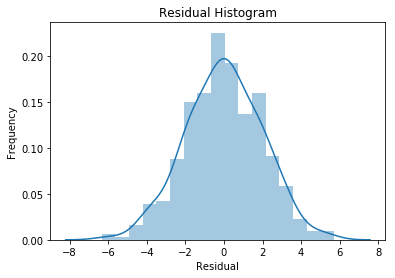

In [69]:
pcr_model = sm.ols(formula = 'childHeight ~ pc1 + pc2 + pc3 + pc4', data=pca_df)

results = pcr_model.fit()
n_points = pca_df.shape[0]
y_output = pca_df['childHeight'].values.reshape(n_points, 1)

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

Here, you may see that the last two principal components are not needed for a significant fit.  You could also have noticed that from the 'explained variance' for each component- and how the last two components explained nearly 4 orders of magnitude less variance.

## Regularization with Ridge and Lasso Regression

So far, we have looked at two approached for dealing with over-parameterized models; feature selection by stepwise regression and singular value decomposition. In this section we will explore the most widely used regularization method for optimization-based machine learning models, **ridge regression**. 

Let's start by examining the matrix-equation formulation of the linear regression problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ and a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

Rewriting this equation,

$$b = A^{-1} (A^{T})^{-1} A^{T}x$$

Or, alternatively,

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is an $m x m$ matrix, and thus is of reduced dimension. But, **$A^TA$ can still be rank deficient!** 

The basic idea of ridge regression is to stabilize the inverse singular value matrix, $D^+=A^{T}A$, by **adding a small bias term**, $\lambda$, to each of the singular values. We can state this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \lambda \cdot b\parallel]\\  or \\
b = (A^TA + \lambda^2)^{-1}A^Tx$$

In this way, the values of small singular values do not blow up when we compute the inverse. You can see this by writing out the $D^+$ matrix with the bias term.

$$D_{ridge}^+  = \begin{bmatrix}
    \frac{1}{d_1 + \lambda^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{d_2 + \lambda^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{d_m + \lambda^2}
\end{bmatrix}$$

Adding this bias term creates a 'ridge' in the singular value matrix, giving this method its name **ridge regression**. 

You can also think of ridge regression as limiting the L2 or Euclidean norm of the values of the model coefficient vector. The value of $\lambda$ determines how much the norm of the coefficient vector constrains the solution. You can see a view of this geometric interpretation in the figure below.  

<img src="https://library.startlearninglabs.uw.edu/DATASCI410/img/L2.jpg" title="Geometric View of L2 regularization" style="height: 300px;">
<center> **Geometric view of L2 regularization**

The same method goes by some other names, as it seems to have been 'invented' several times. In particular, **Tikhonov regularization**, or **L2 norm regularization**. In all likelihood the method was first developed by the Russian mathematician Andrey Tikhonov in the late 1940s, and first published in English in 1977.

Let's give this a try. Execute the code in the cell below which computes the $(A^TA + \lambda^2)^{-1}A^T$ matrix with a lambda value of `0.1`.

In [71]:
U, s, V = np.linalg.svd(M, full_matrices=False)

# Calculate the inverse singular value matrix from SVD
lambda_val = 1.0
d = np.diag(1. /  (s + lambda_val))

print('Inverse Singular Value Matrix:')
print(d)

# Compute pseudo-inverse
mInv = np.dot(np.transpose(V), np.dot(d, np.transpose(U)))

print('M Inverse')
print(mInv)

Inverse Singular Value Matrix:
[[0.03022051 0.         0.         0.        ]
 [0.         0.03354784 0.         0.        ]
 [0.         0.         0.70606532 0.        ]
 [0.         0.         0.         0.72727721]]
M Inverse
[[ 0.00455311  0.0037282   0.0037282  ...  0.0111813   0.0111813
   0.0111813 ]
 [-0.21447234 -0.08812802 -0.08812802 ...  0.01207399  0.01207399
   0.01207399]
 [-0.00289452 -0.00214762 -0.00214762 ... -0.01022436 -0.01022436
  -0.01022436]
 [ 0.22302115  0.09381338  0.09381338 ... -0.01277817 -0.01277817
  -0.01277817]]


Now we compute the model coefficients using the $(A^TA + \lambda^2)^{-1}A^T$ matrix we just computed.

In [72]:
beta_coeffs_ridge = np.dot(mInv, childHeight)
print('Beta\'s: {}'.format(beta_coeffs_ridge))

Beta's: [-0.36589486  0.69965326  1.12147485  0.21541252]


### Bias-variance Trade-off

The statsmodels package allows us to compute a sequence of ridge regression solutions.  The function that does this uses a method called 'elastic-net', know that ridge regression is a specific case of elastic-net, and we will talk more about this later.

The code in the cell below computes solutions for `20` values of $\lambda$. Execute this code and examine the values of the model coefficients as $\lambda$ increases. We'll use the `numpy` method `np.linspace` to compute sequence of lambdas.

In [123]:
# Ridge Regression with various penalties in Statsmodels
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'childHeight ~ mother + father + mother_sqr + father_sqr + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=0)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), childHeight)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(childHeight - np.mean(childHeight)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

Text(0.5, 0, 'Log-Lambda')

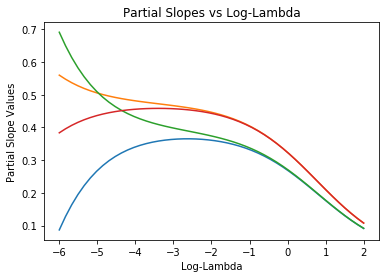

In [124]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

In [126]:
#beta_coeffs

Text(0, 0.5, 'Partial Slopes')

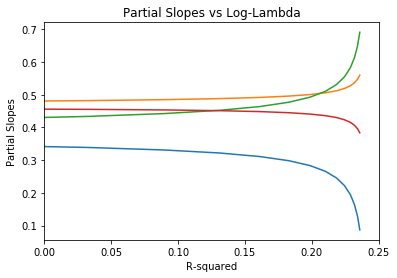

In [75]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs Log-Lambda')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

> Notice that $\lambda$ increases, the values of the 4 model coefficients decrease toward zero. When all coefficients are zero, the model predicts all values of the label as zero! In other words, high values of $\lambda$ give highly biased solutions, but with very low variance. For small values of $\lambda$, the situation is just the opposite. The solution has low bias, but is quite unstable, having maximum variance. This **bias-variance trade off** is a key concept in machine learning.

> Also note how we can get a significant increase in R^2 (from 0 --> ~0.20) without changing the partial slopes much.



----------------------------
### Lasso Regression
----------------------------

We can also do regularization using other norms. **Lasso or L1 regularization** limits the sum of the absolute values of the model coefficients. The L1 norm is sometime know as the **Manhattan norm**, since distances are measured as if you were traveling on a rectangular grid of streets. 

You can also think of lasso regression as limiting the L1 norm of the values of the model coefficient vector. The value of $\lambda$ determines how much the norm of the coefficient vector constrains the solution. You can see a view of this geometric interpretation in the figure below.  

<img src="https://library.startlearninglabs.uw.edu/DATASCI410/img/L1.jpg" title="Geometric view of L1 regularization" style="height: 300px;">
<center> **Geometric view of L1 regularization**

By setting the `alpha` argument to the statsmodels functions to zero you can perform lasso regression. Execute the code in the cell below to compute and evaluate a lasso regression model with 20 values of lambda.

In [76]:
# Lasso Regression with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'childHeight ~ mother + father + mother_sqr + father_sqr + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=1)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), childHeight)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(childHeight - np.mean(childHeight)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

Text(0.5, 0, 'Log-Lambda')

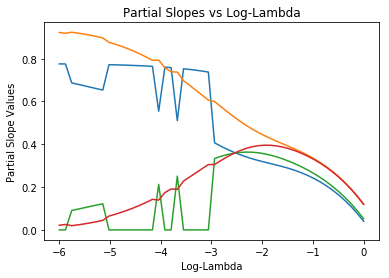

In [119]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

Text(0, 0.5, 'Partial Slopes')

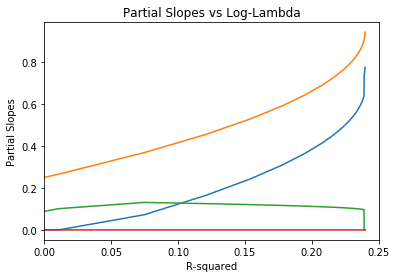

In [78]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs Log-Lambda')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

Notice that model coefficients are much more tightly constrained than for L2 regularization. In fact, only two of the possible model coefficients have non-zero values at all. This is typical of L1 or lasso regression.

---------------
### Elastic Net Regression
---------------

The **elastic net** algorithm uses a weighted combination of L2 and L1 regularization. As you can probably see, the same function is used for Lasso and Ridge regression with only the `L1_wt` argument changing. This argument determines the how much weight goes to the L1-norm of the partial slopes. If `L1_wt = 0`, the regularization is pure L2 (Ridge) and if `L1_wt = 1.0` the regularization is pure L1 (Lasso).

The code in the cell below gives equal weight to each regression method. Execute this code and examine the results.

In [79]:
# Elasticnet Regression with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 0, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'childHeight ~ mother + father + mother_sqr + father_sqr + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=0.75)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), childHeight)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(childHeight - np.mean(childHeight)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

In [114]:
ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=-6, L1_wt=0.75)
ridge_model.params

Intercept     1.356077e+25
mother       -5.553171e+39
father       -8.734618e+39
mother_sqr   -1.375688e+40
father_sqr   -2.163852e+40
dtype: float64

Text(0.5, 0, 'Log-Lambda')

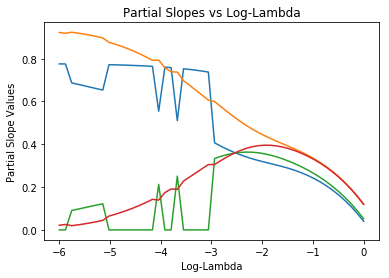

In [80]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

Text(0, 0.5, 'Partial Slopes')

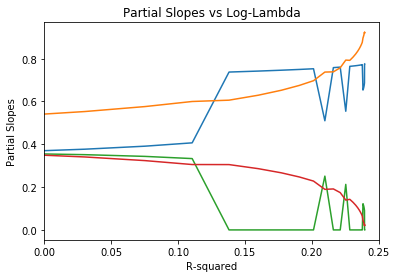

In [81]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs Log-Lambda')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

Notice that the elastic net model combines some of the behaviors of both L2 and L1 regularization. 

## Categorical Variables and the Model Matrix

Up until now we have only been working with numeric data. How can we handle categorical variables in numeric models? 

We need to encode the categorical variables into one or more numeric variables. The common approach is to convert the categorical variable to a set of binary **dummy variables** or **indicator variables**. 

The code in the cell below computes the scaled model data frame. Execute this code and examine the summary of the data frame.

In [82]:
# Full original Family dataset
family_data[0:3]

,family,father,mother,gender,childHeight,kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4


In [83]:
# Create new data frame for new feature set
height_df = family_data.copy()

# Add in squares of mother and father heights
height_df['father_sqr'] = height_df['father'] **2
height_df['mother_sqr'] = height_df['mother'] **2

# Drop columns for family, kids
Obsolete = ["family", "kids"]
for x in Obsolete:
    height_df = height_df.drop(x, axis=1)
    
# Reset the index
male_df=male_df.reset_index(drop=True)

# preview the data
height_df.head()

,father,mother,gender,childHeight,father_sqr,mother_sqr
0,78.5,67.0,M,73.2,6162.25,4489.00
1,78.5,67.0,F,69.2,6162.25,4489.00
2,78.5,67.0,F,69.0,6162.25,4489.00
3,78.5,67.0,F,69.0,6162.25,4489.00
4,75.5,66.5,M,73.5,5700.25,4422.25


In [84]:
# Add scaled x to data frame
height_df['father'] = scale(height_df['father'])
height_df['mother'] = scale(height_df['mother'])
height_df['father_sqr'] = scale(height_df['father_sqr'])
height_df['mother_sqr'] = scale(height_df['mother_sqr'])

print(height_df.head())

     father    mother gender  childHeight  father_sqr  mother_sqr
0  3.753584  1.264492      M         73.2    3.974347    1.281902
1  3.753584  1.264492      F         69.2    3.974347    1.281902
2  3.753584  1.264492      F         69.0    3.974347    1.281902
3  3.753584  1.264492      F         69.0    3.974347    1.281902
4  2.538458  1.047642      M         73.5    2.627177    1.054857


Intercept, Slopes : 
Intercept      64.052077
gender[T.M]     5.230829
father         -0.327971
mother         -1.569432
father_sqr      1.327141
mother_sqr      2.310222
dtype: float64
Intercept t-value, Slope t-values: 
Intercept      616.901952
gender[T.M]     36.174581
father          -0.128882
mother          -0.562081
father_sqr       0.521375
mother_sqr       0.827234
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept       0.000000e+00
gender[T.M]    4.251455e-177
father          8.974804e-01
mother          5.742019e-01
father_sqr      6.022349e-01
mother_sqr      4.083257e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 7370.652331224212
SST: 11515.062371937638
SSR: 4144.4100407134265
RMSE: 38.394406705206976
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:           

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residual Histogram')

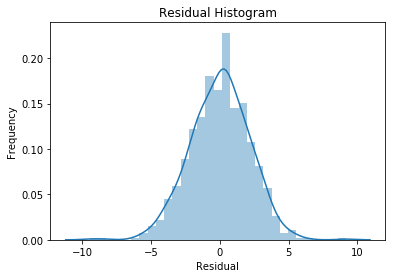

In [86]:
# Fit the OLS with the categorical field 'gender':
ols_model = sm.ols(formula = 'childHeight ~ father + mother + father_sqr + mother_sqr + gender + 1', data=height_df)

results = ols_model.fit()
n_points = height_df.shape[0]
# y_output = height_df['childHeight'].reshape(n_points, 1)
y_output = height_df['childHeight'].values.reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

------------------
## Total Regression
### Also known as Demming Regression or Orthagonal Distance Regression
------------------

Another case of regression we may be interested in is minimizing the total error.  By total error, we mean minimizing the error in the y-values _and_ the x-values.  Here, we will be interested in minimizing the distance between the point and the best fit line for all points.

A visual explanation of the distance we wish to minimize is in the following figure.  Regular regression minimizes the grey-vertical lines.  Total Regression will minimize the dashed red lines.

<img src="https://library.startlearninglabs.uw.edu/DATASCI410/img/total_vs_leastsquares.png" alt="Total Regression Errors" style="width: 400px;"/>

### When would you use Total Regression?

 - When you have uncertainty in both the y-values _and_ the x-values.
 - When both the x and y values are the same scales and units.
   - Note that it is recommended to scale both the y and x before total regression.
   - There are alternative methods here that will scale the distance metric to be proportional to both the x and y measurement scales. However, such methods are not covered in this class and left to the reader.  For more detail on how to accomplish this, read the documentation in the scipy docs here: https://docs.scipy.org/doc/scipy-0.18.1/reference/odr.html

In [87]:
# Description of method:
#    https://docs.scipy.org/doc/scipy-0.18.1/reference/odr.html

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
import numpy as np

# Create test data
x = np.linspace(start=0, stop=20., num=25)
y = x + np.random.normal(size=25, scale=5)
my_data = Data(x, y)
my_data_df = pd.DataFrame({'x': x, 'y': y})

# Define a linear function.
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    return B[0]*x + B[1]

# Instantiate the linear model
linear = Model(f)

# Create the model with initial parameter guesses
total_regression_model = ODR(my_data, linear, beta0=[1., 1.])

# Fit the model
total_reg_results = total_regression_model.run()

# Print results
total_reg_results.pprint()

total_slope = total_reg_results.beta[0]
total_intercept = total_reg_results.beta[1]
print('\nTotal Regression:')
print('\n  -Slope: {}'.format(total_slope))
print('\n  -Intercept: {}'.format(total_intercept))

total_y_fit = [total_slope * xi + total_intercept for xi in x]

Beta: [ 1.49546929 -5.58575246]
Beta Std Error: [0.18508561 2.11768506]
Beta Covariance: [[ 0.00418802 -0.04188024]
 [-0.04188024  0.54825982]]
Residual Variance: 8.179680294151344
Inverse Condition #: 0.0409489777677758
Reason(s) for Halting:
  Sum of squares convergence

Total Regression:

  -Slope: 1.4954692920067767

  -Intercept: -5.5857524637230105


Let's compare the results graphically to regular regression.

In [88]:
ols_model = sm.ols(formula = 'y ~ x', data=my_data_df)

results = ols_model.fit()
n_points = my_data_df.shape[0]
y_output = my_data_df['y'].values.reshape(n_points, 1)

reg_slope = results.params[1]
reg_intercept = results.params[0]
print('\nRegular Regression:')
print('\n  -Slope: {}'.format(reg_slope))
print('\n  -Intercept: {}'.format(reg_intercept))

reg_y_fit = [reg_slope * xi + reg_intercept for xi in x]

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
# print(results.summary())


Regular Regression:

  -Slope: 1.1838331572134253

  -Intercept: -2.4693911703008844

SSE, SST, SSR, and RMSE:
SSE: 1265.2077967731093
SST: 1786.4104962224824
SSR: 521.202699449373
RMSE: 35.569759582728544


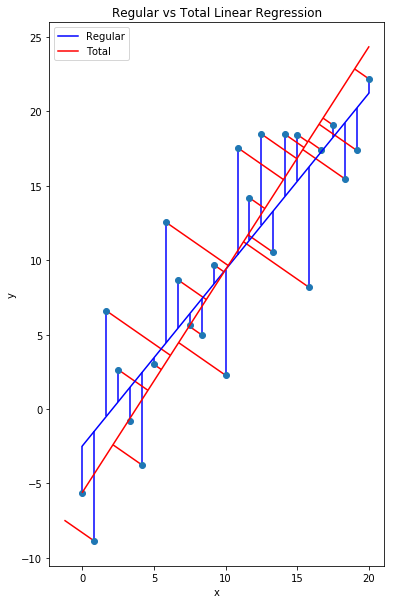

In [89]:
from matplotlib import collections  as mc
import pylab as pl

# More terse equations:
m = total_slope
b = total_intercept

# Loop through and draw vertical + total regression errors
total_errs = []
reg_errs = []
for xi, yi, totaly, regy in zip(x, y, total_y_fit, reg_y_fit):
    # Total reg. error segment
    x_t = (yi + xi/m - b) / (m + 1/m)
    y_t = m * x_t + b
    temp_total_err = [(x_t, y_t), (xi, yi)]
    total_errs.append(temp_total_err)
    # Regular reg. error segment
    temp_reg_err = [(xi, regy), (xi, yi)]
    reg_errs.append(temp_reg_err)

reg_lc = mc.LineCollection(reg_errs, colors='blue')
total_lc = mc.LineCollection(total_errs, colors='red')
fig, ax = pl.subplots(figsize=(6, 10))
ax.add_collection(reg_lc)
ax.add_collection(total_lc)

plt.plot(x, y, 'o')
plt.plot(x, reg_y_fit, color='blue', label='Regular')
plt.plot(x, total_y_fit, color='red', label='Total')

plt.title('Regular vs Total Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Let's compare the SSR's:

In [90]:
ssr_reg = results.ssr
ssr_total = np.sum([(yi - y_hat)**2 for yi, y_hat in zip(y, total_y_fit)])

print('Regular SSE: {}'.format(ssr_reg))
print('Total SSE: {}'.format(ssr_total))

Regular SSE: 521.202699449373
Total SSE: 608.8778415754995


This is as expected, because both SSR computations here based off the vertical distance.  Let's compute a new SSR for the total regression that is the sum-squared of the total-errors.

We have prior calculated all pairs of points, in the variable, `total_errs`.  Let's use that to compute a new SSR.

In [91]:
squared_errs = []
for pair in total_errs:
    temp_squared_dist = (pair[0][1] - pair[1][1])**2 + (pair[0][0] - pair[1][0])**2
    squared_errs.append(temp_squared_dist)
    
new_total_ssr = np.sum(squared_errs)
print('New Total SSE: {}'.format(new_total_ssr))

New Total SSE: 188.13264676210053


> Note, however, it is harder to define the SST here, and as a result, any definition of an $R^{2}$ metric is arbitrary and not-comparable.

## Logistic Regression

Until now, we have been working strictly with linear regression models. Now we will look at a widely used variation on the linear model know as **logistic regression**.

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`.  However, the response is computed as a log likelihood. In the simplest case, the response has a Binomial distribution. 

The response of the linear model is transformed to the log likelihood using a sigmoidal function, also known as the **logistic function**:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

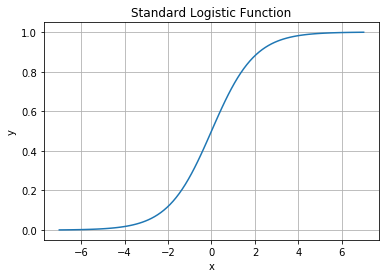

In [92]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center=0, scale=1):
    e = np.exp(-scale*(x-center))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

log_y = log_fun_vectorized(x_seq)

plt.plot(x_seq, log_y)
plt.title('Standard Logistic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continuous output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$

### Classification Example

Next, we will try to classify the gender of the children in the Galton height data set using logistic regression on the height data.

As a first step, we need to create a scaled model matrix of the features for the logistic regression. Run the code in the cell below to compute this matrix.

In [93]:
# The logit function in Stats models does not take formulas,
#     instead we have to give it arrays/matrices.
#     This is very common with ML in python, so it is a good
#     time to get familiar with the format.

# Create intercept column
height_df['intercept'] = 1.0

X_cols = ['father', 'mother', 'childHeight', 'intercept']

X = height_df[X_cols]
Y = np.array([1 if x=='F' else 0 for x in height_df['gender']])

logit_model = sm.Logit(Y, X)

result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.267542
         Iterations 8


In [95]:
X.head()

,father,mother,childHeight,intercept
0,3.753584,1.264492,73.2,1.0
1,3.753584,1.264492,69.2,1.0
2,3.753584,1.264492,69.0,1.0
3,3.753584,1.264492,69.0,1.0
4,2.538458,1.047642,73.5,1.0


In [96]:
# Fix pending for issue in statsmodels:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  898
Model:                          Logit   Df Residuals:                      894
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Feb 2019   Pseudo R-squ.:                  0.6137
Time:                        18:55:50   Log-Likelihood:                -240.25
converged:                       True   LL-Null:                       -621.88
                                        LLR p-value:                4.045e-165
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
father          1.1422      0.136      8.394      0.000       0.876       1.409
mother          0.8534      0.127      6.728      0.000       0.605       1.102
childHeight    -1.1044      0.074    -14.920    

We can generate a `alpha` level of confidence around the parameter estimates with the result method `results.conf_int(alpha=...)` as follows.

In [97]:
# Confidence intervals
# alpha is the % confidence in parameters.
print(result.conf_int(alpha=0.90))

                     0          1
father        1.125088   1.159285
mother        0.837493   0.869372
childHeight  -1.113742  -1.095138
intercept    72.821409  74.057817


### Interpretation of Parameters

If we are interested in how the output probabilities change with respect to the features, we can look at the odds ratio. The odds ratio is just the exponential of the parameters.

These tell us how a 1 unit increase or decrease in a variable affects the odds of being predicting a '1' (female). For example, we can expect the odds of predicting a female gender to decrease by about 65.9% if we find the childHeight goes down by 1.

In [98]:
# Odds ratio
print(np.exp(result.params))

father         3.133612e+00
mother         2.347691e+00
childHeight    3.313964e-01
intercept      7.841856e+31
dtype: float64


Here is how we can make predictions with our model:

In [99]:
# Standardized Father, Standardized Mother, ChildHeight, 1.0 (intercept)
test_input = np.array([3.7, 1.26, 70.1, 1.0])
test_output = result.predict(test_input)
print('Probability of Female: {0:.2f}%'.format(test_output[0]*100.))

Probability of Female: 78.91%


Finding out the effect of `childHeight` on the probabilities graphically:

Here we will loop over a sequence of childHeights to see the effect of them on the probability of a female gender.

In [100]:
childHeight_seq = np.linspace(height_df['childHeight'].min(), height_df['childHeight'].max(), 100)

avg_father = height_df['father'].mean()
avg_mother = height_df['mother'].mean()

childHeight_df = pd.DataFrame(childHeight_seq, columns=['childHeight'])
childHeight_df['father'] = height_df['father'].mean() # hopefully close to zero
childHeight_df['mother'] = height_df['mother'].mean() # hopefully close to zero
childHeight_df['intercept'] = 1.0

# Rearrange order of columns appropriately
childHeight_df = childHeight_df[['father', 'mother', 'childHeight', 'intercept']]

# Get probability predictions
gender_prob_childHeight = result.predict(childHeight_df)

In [101]:
childHeight_df.head()

,father,mother,childHeight,intercept
0,1.551753e-14,8.085589e-16,56.000000,1.0
1,1.551753e-14,8.085589e-16,56.232323,1.0
2,1.551753e-14,8.085589e-16,56.464646,1.0
3,1.551753e-14,8.085589e-16,56.696970,1.0
4,1.551753e-14,8.085589e-16,56.929293,1.0


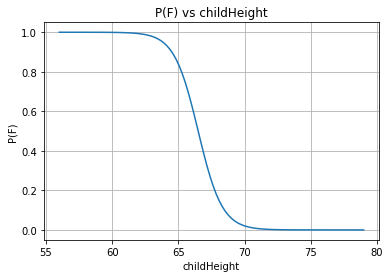

In [102]:
plt.plot(childHeight_seq, gender_prob_childHeight)
plt.title('P(F) vs childHeight')
plt.xlabel('childHeight')
plt.ylabel('P(F)')
plt.grid()

We are also interested in evaluating our classifier's accuracy.  Here we will look at how many are:

 - True Positives (TP): We predicted female and the actual gender was female.
 - True Negatives (TN): We predicted male and the actual gender was male.
 - False Positives (FP): We predicted female and the actual gender was male.
 - False Negatives (FN): We predicted male and the actual gender was female.

The output of our predictions is a probability.  In order to make this a binary prediction (female or male), we need to decide a cutoff. Commonly, we choose 0.5 as a cutoff. But know that this choice is arbitrary and we can set it to whatever probability we choose. If we have a model where false positives are costly, we might decide to increase the cutoff, and vice-versa if false negatives are more costly.

In [103]:
prediction_frame = X.copy()

prediction_frame['probability'] = result.predict(X)

prediction_frame['actual'] = Y

cutoff = 0.5
def prediction_fun(row):
    if row['probability'] > 0.5:
        return 1.0
    else:
        return 0.0
    

prediction_frame['prediction'] = prediction_frame.apply(prediction_fun, axis=1)

In [104]:
prediction_frame.head()

,father,mother,childHeight,intercept,probability,actual,prediction
0,3.753584,1.264492,73.2,1.0,0.115174,0,0.0
1,3.753584,1.264492,69.2,1.0,0.915197,1,1.0
2,3.753584,1.264492,69.0,1.0,0.930842,1,1.0
3,3.753584,1.264492,69.0,1.0,0.930842,1,1.0
4,2.538458,1.047642,73.5,1.0,0.019017,0,0.0


Now let's calculate the accuracy, true positives, true negatives, false positives, and false negatives.

In [105]:
TP = np.sum([a == 1.0 and p == 1.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])
TN = np.sum([a == 0.0 and p == 0.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])

FP = np.sum([a == 0.0 and p == 1.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])
FN = np.sum([a == 1.0 and p == 0.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])

num_obs = prediction_frame.shape[0]

print('Out of {} observations:'.format(num_obs))
print('TP: {}, TN: {}'.format(TP, TN))
print('\nFP: {}, FN: {}'.format(FP, FN))

accuracy = (TP + TN) / num_obs
print('\nAccuracy over two classes: {0:.2f}%'.format(accuracy*100.))

Out of 898 observations:
TP: 384, TN: 411

FP: 54, FN: 49

Accuracy over two classes: 88.53%


### Confusion Matrix
We can view these results in a table with a confusion matrix as follows:

In [106]:
print('Actual = columns')
print('\nPredicted = rows')
print('\n   0.0   1.0')
print('----------------')
print(result.pred_table(threshold=cutoff))

Actual = columns

Predicted = rows

   0.0   1.0
----------------
[[411.  54.]
 [ 49. 384.]]


In the confusion matrix, males are defined as positive cases and females are negative cases. Notice that most of the cases in this data are correctly classified with only a few false negatives and false positives.

The other metrics are defined as follows:

- Accuracy = (TP + TN) / (TP + FP + TN + FN)
- Precision = TP / (TP + FP)
   - Precision is the fraction of the relevant class predictions are actually correct.
- Recall = TP / (TP + FN)
   - Recall is the fraction of the relevant class were we able to predict.

These summary statistics show the classifier works fairly well.

### Summary
In this notebook, we looked at 3 methods as a solution to the problem of overfit models:

* Stepwise Regression to eliminate features one at a time
* Singular Value Decomposition to find meaningful features
* Lasso, Ridge, and Elastic-net Regularization to stabilize over-parameterized models

Important terms from this notebook include:

* AIC - the model log-likelihood adjusted for the number of model parameters
* Deviance - a measure of the relative likelihood of the model (generalization of variance)
* Conformable - number of rows of first matrix equals the number of columns of the second matrix, number of columns of first matrix equals number of rows of the second matrix
* SVD - Singular Value Decomposition describes a matrix as linear combination of a series of vectors $U$, $V$, $D$
* Singular values $s$ - the diagonal matrix of singular values used as a scaling term
* Rank deficient matrix - has one or more of the $m$ singular values  $d_i  \sim 0.0$  
* Lambda - a small bias term added to singular values to stabilize the inverse singular value matrix
* PCA - Principal Component Analysis to determine what new features can be made from linear combinations that are independent of each other by using functions and the SVD
* PCR - Principal Component Regression uses the PCA to perform a "regularized" regression.
* L2 Norm regularization - Ridge regularization limiting the Euclidean norm of values of the model coefficient vector
* L1 regularization - Lasso regularization using the Manhattan norm
* Elastic-net algorithm - a weighted combination of L2 and L1 regularization
* Total regression - minimizes the distance between the point and the best fit line for all points
* Logistic regression - a linear model, with a binary response (Binomial distribution) using the logistic function on the response to transform it into a log likelihood


And we reviewed Linear Algebra operations:
* Adding vectors and matrices
* Multiplying vectors and matrices
* Transposing matrices with `np.transpose`
* Dot product or scalar product or inner product with `np.dot`
* L2 norm of a vector
* Identity matrix with `np.eye`
* Inverse of a matrix with `np.linalg.inv`
* Singular value decomposition with `np.linalg.svd`
* Creating a diagonal matrix with `np.diag`




<div id="reminder" style="border-radius: 5px; background-color:#f5f5f5;" >
<h3>Reminder</h3>
<p>Use this notebook to answer the quiz questions related to the <b>Your Turn</b> sections.<p>
</div>